# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 

#### Submitted by Cristian Alberch as part of Udacity Self Driving Car Engineering Nanodegree - January 2021

### Overview

When we drive, we use our eyes to decide where to go. The lines on the road that show us where the lanes are act as our constant reference for where to steer the vehicle. Naturally, one of the first things we would like to do in developing a self-driving car is to automatically detect lane lines using an algorithm.

This is an project is will detect lane lines in video images using Python and OpenCV without the use of machine learning techniques and produce an output video showing the lane area. 

The pipeline used to produce the output video:

#### 1. Camera Calibration: 
A set of sample checkerboard images are used to calculate the necessary camera calibration to produce a distortion free image.

#### 2. Horizontal Image Crop: 
The road image of interest is cropped horizontally to display the road area only.

#### 3. Sobel Operators: 
Apply Sobel operators to transform the image from color to black & white with emphasis on road lane features. The Sobel operators applied include magnitude, direction (x & y axis), and gradient. The image is then processed to identify lane markings according to Hue-Saturation-Level.

#### 4. Region of Interest: 
The filtered image is cropped to identify only the road-only region of interest.

#### 5. Perspective Transform: 
The image is warped to show a birds eye view.

#### 6. Perspective Lane Selection: 
The birds eye view is subsequently cropped to reduce the width of the image for lane identificaiton.

#### 7. Polynomial Regression Estimate: 
The pixels in the lane identification are used to produce a best-fit 2nd order polynomial regression curve modelling the lane curve.

#### 8. Regression Estimate Value Checks: 
The left and right lane curves are verified for congruence, considering that the distance between the lanes is constant. The values are further averaged over the previous 10 image frames to reduce jaggedness and ensure the predicted path is consistent with the previous images.

#### 9. Radius of Curvature: 
The curvature radius is calculated according to the estimated lane curve and 2nd order polynomial coefficients.

#### 10. Image Overlay: 
An overlay fill is superimposed to the original image based on the lane curves identified.

#### 11. Text Overlay: 
The curvature radius value is overlayed to the image output.

### Import Packages

In [1148]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline
from collections import deque
from numpy import matrix

### Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


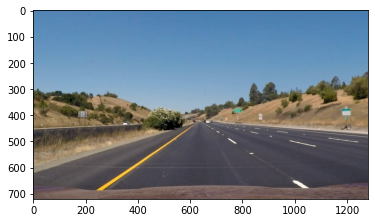

In [1149]:
#reading in an image
image = mpimg.imread('test_images_notes/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

### 1. Camera Calibration

In [1150]:
# Code references: 
# Udacity Self-Driving Cars Nanodegree
# https://www.learnopencv.com/camera-calibration-using-opencv/

# Read in the saved camera matrix and distortion coefficients

def calibration_points(checkerboard):

    # Creating vector to store vectors of 3D points for each checkerboard image
    objpoints = []

    # Creating vector to store vectors of 2D points for each checkerboard image
    imgpoints = []

    # World coordinates for 3D points
    objp = np.zeros((1, checkerboard[0] * checkerboard[1], 3), np.float32)
    objp[0,:,:2] = np.mgrid[0:checkerboard[0], 0:checkerboard[1]].T.reshape(-1, 2)

    # loop through calibration files
    for file in range(1,21,1):
        filename = 'camera_cal/calibration'+str(file)+'.jpg'
        img = mpimg.imread(filename)

        # Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find corners
        ret, corners = cv2.findChessboardCorners(gray, (checkerboard[0], checkerboard[1]), None)
        # If corners found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            #draw and display the corners
            img = cv2.drawChessboardCorners(img, (checkerboard[0], checkerboard[1]), corners, ret)

            plt.imshow(img)
            plt.show()
            
    return imgpoints, objpoints

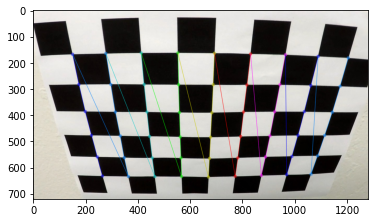

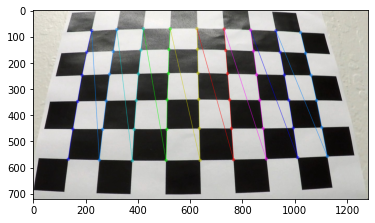

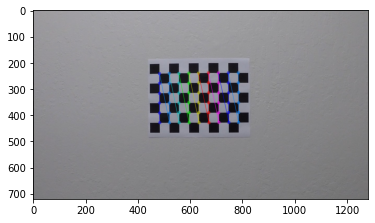

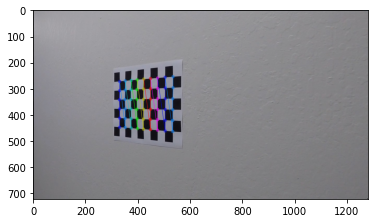

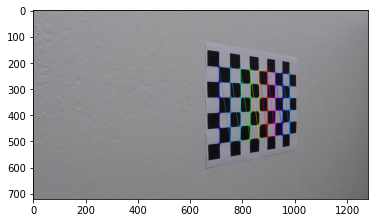

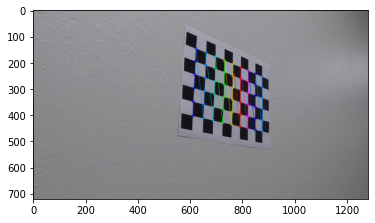

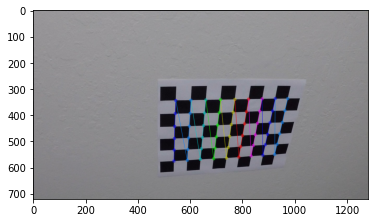

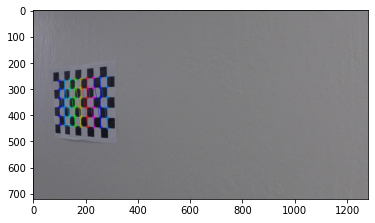

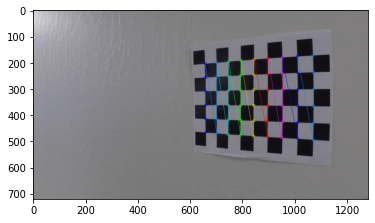

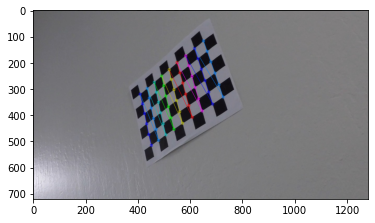

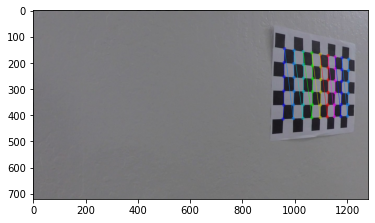

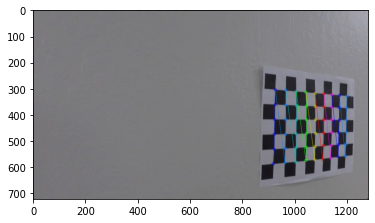

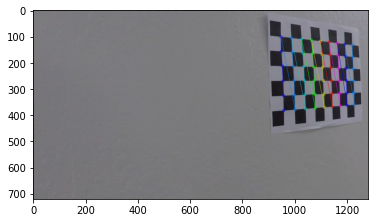

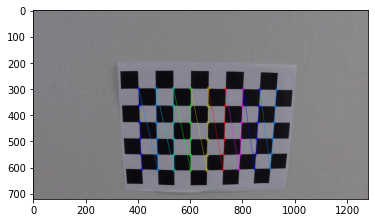

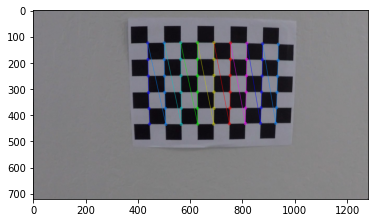

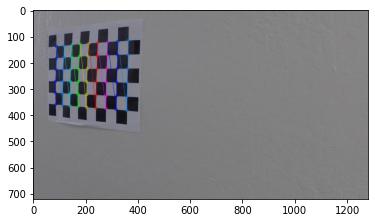

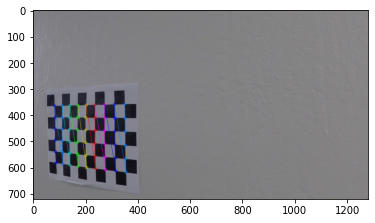

In [1151]:
# Determine image points and object points of checkerboard photos
imgpoints, objpoints = calibration_points(checkerboard = (6,9))

In [1152]:
def cal_undistort(img, objpoints, imgpoints):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

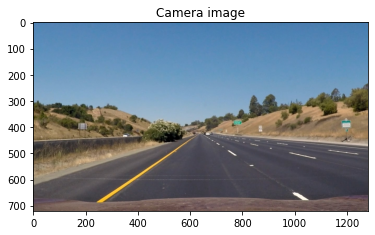

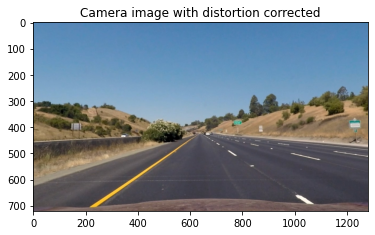

In [1153]:
# Undistort test image to test camera calibration effectiveness

img = mpimg.imread('test_images_notes/straight_lines1.jpg')
plt.imshow(img)
plt.title("Camera image")
plt.show()

img_undistorted = cal_undistort(img, objpoints, imgpoints)
plt.imshow(img_undistorted)
plt.title("Camera image with distortion corrected")
plt.show()

### 2. Horizontal Image Crop

In [1158]:
def horizontal_crop(img):
    ## cropping image to show Region Of Interest:
    img=img[440:680, 0:1280]
    return img

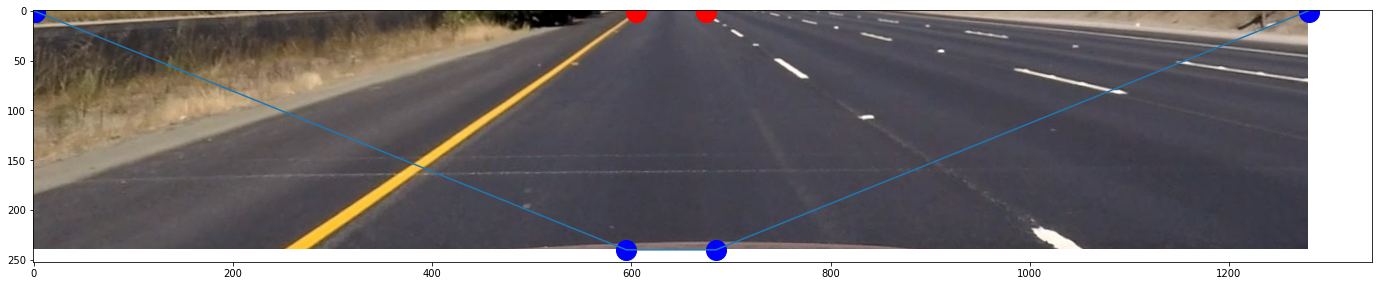

In [1159]:
plt.figure(figsize=(24,128))
plt.imshow(horizontal_crop(img_undistorted))
plt.plot(605,1,"bo",markersize=20, color ='r')
plt.plot(675,1,"bo",markersize=20, color='r')

plt.plot(1,1,"bo",markersize=20, color='b')
plt.plot(595,240,"bo",markersize=20, color='b')
plt.plot(685,240,"bo",markersize=20, color='b')
plt.plot(1280,1,"bo",markersize=20, color='b')
plt.plot([0,595,685,1280], [0,240,240,0])


### 3. Sobel Operators

In [1154]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1


    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image

    return binary_output

def hls_color(img, s_thresh=(190, 255), sx_thresh=(40, 80)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

In [1163]:
def threshold_binary(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(30, 180))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=5, thresh=(50, 160))
    mag_binary = mag_thresh(img, sobel_kernel=7, mag_thresh=(50, 160))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.8, 1.3))
    combined_thresh = np.zeros_like(dir_binary)
    combined_thresh[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_hls=hls_color(img, s_thresh=(100, 255), sx_thresh=(40, 80))/255
    combined_thresh_hls = np.zeros_like(dir_binary)
    combined_thresh_hls=combined_hls[:,:,1] + combined_hls[:,:,2] + combined_thresh
    combined_thresh_hls=np.clip(combined_thresh_hls, a_min = 0, a_max = 1)        
    return combined_thresh_hls

Text(0.5, 1.0, 'Combined thresholds')

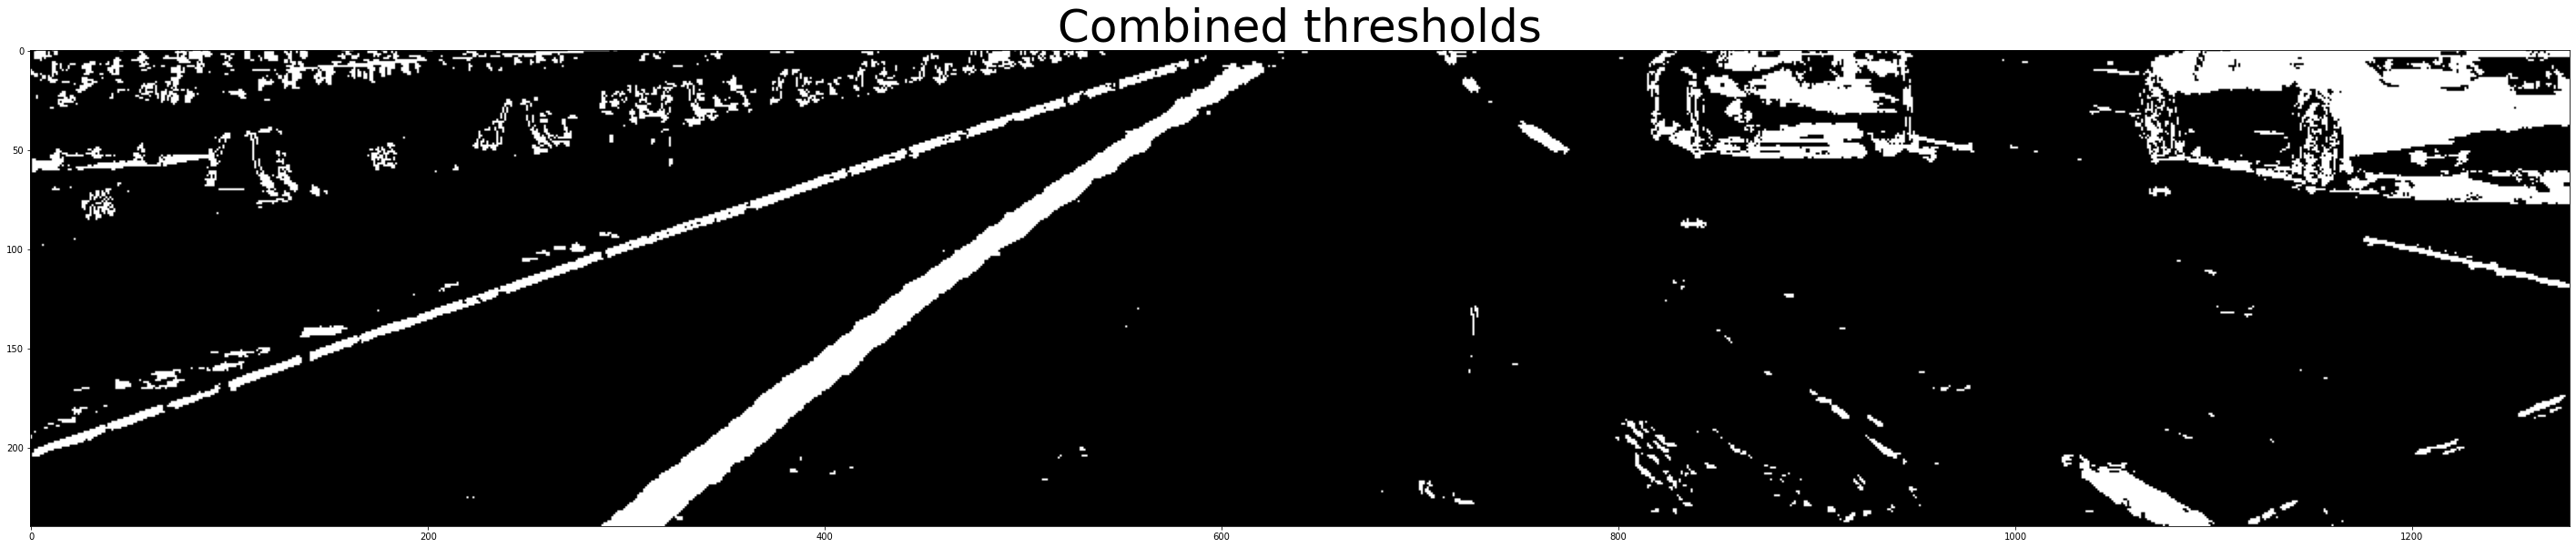

In [1164]:
image = mpimg.imread('test_images_notes/fuzzy_lines1.jpg')
img=image.copy()
img=cal_undistort(img, objpoints, imgpoints)
img=horizontal_crop(img)

#hyperparameters
img=threshold_binary(img)
#img=warp(img)

fig, ax = plt.subplots(figsize=(50, 20))
ax.imshow(img, cmap = 'gray')
ax.set_title('Combined thresholds', fontsize=50)

### 4. Region of Interest

In [1162]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    vertices = np.array([[(200,240),(560,0),(760,0),(1200,240)]],dtype=np.int32)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
        
    # mask by multiplication, clip to range 0 to 255 and make integer
    result = (img * mask).clip(0, 1).astype(np.uint8)
    
    return result

### 5. Perspective Transform

In [1160]:
def warp(img_roi):

    #source points: the entire borders are selected
    src = np.float32([[0, 240], [1280, 240], [0, 0], [1280, 0]])

    #destination points: the vanishing point is inverted to be directed to viewer point
    dst = np.float32([[595, 240], [685, 240], [0, 0], [1280, 0]])

    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix

    img_warped = cv2.warpPerspective(img_roi, M, (1280, 240)) # Image warping

    return img_warped

Text(0.5, 1.0, 'Combined thresholds')

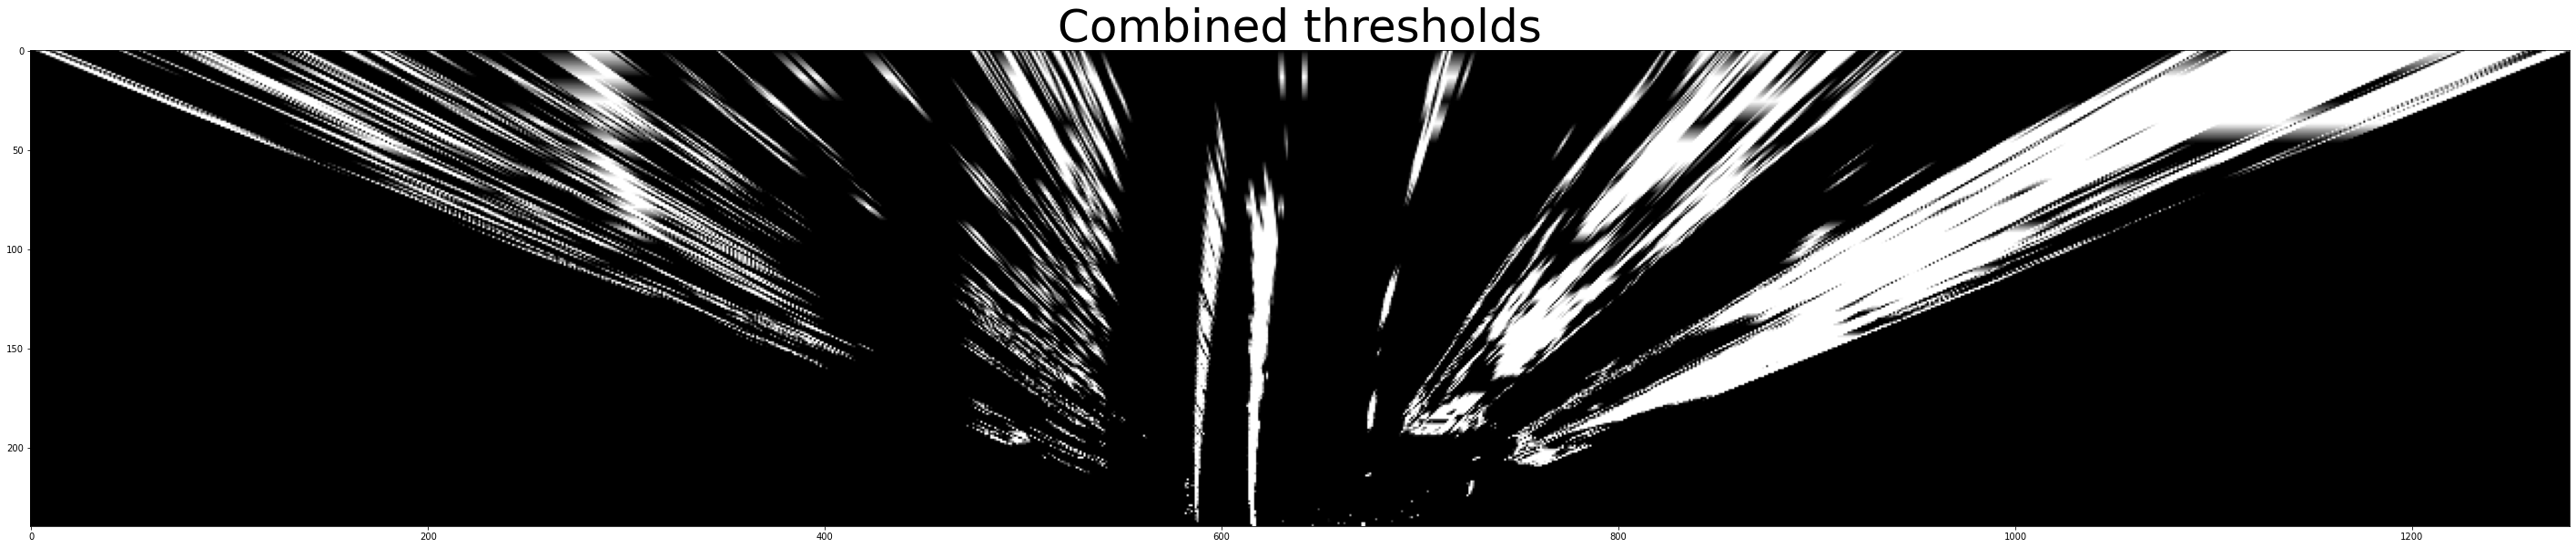

In [1165]:
img=warp(img)

fig, ax = plt.subplots(figsize=(50, 20))
ax.imshow(img, cmap = 'gray')
ax.set_title('Combined thresholds - Birds eye', fontsize=50)

In [1161]:
def warp_inverse(img_roi):

    #source points: the entire borders are selected
    src = np.float32([[0, 240], [1280, 240], [0, 0], [1280, 0]])

    #destination points: the vanishing point is inverted to be directed to viewer point
    dst = np.float32([[595, 240], [685, 240], [0, 0], [1280, 0]])

    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

    img_warped_inv = cv2.warpPerspective(img_roi, Minv, (1280, 240)) # Image warping

    return img_warped_inv

### 6. Perspective Lane Selection

In [1166]:
def vertical_lane_crop (img):
    margin = 40
    left_lane_edge = 605
    right_lane_edge = 675
    img_lane= img[:, left_lane_edge-margin:right_lane_edge+margin]
    
    return img_lane

In [1167]:
def vertical_lane_uncrop (img_lane):
    margin = 40
    left_lane_edge = 605
    right_lane_edge = 675
    img_lane_out = np.zeros((240,1280,3), np.uint8)
    img_lane_out[:, left_lane_edge-margin:right_lane_edge+margin] = img_lane
    return img_lane_out

In [1168]:
def img_lane_overlay(img_lane, img_original):
    
    img_lane_scale = warp_inverse(img_lane)   
    img_lane_mask = np.zeros_like(image)
    img_lane_mask[440:680,:,:] = img_lane_scale
    img_overlay = cv2.addWeighted(img_lane_mask, 1, img_original, 1, 0)

    return img_overlay

### 7. Polynomial Regression Estimate

In [1169]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    img_out = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 6#12 #9 before
    # Set the width of the windows +/- margin
    margin = 20#20#10  ####original 100 - 20 was working ok ish
    # Set minimum number of pixels found to recenter window
    minpix = 20#30#20# the higher the number, the more inertia the line - 20 was working okish

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(img_out,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(img_out,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, img_out


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, img_out = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    img_out[lefty, leftx] = [255, 0, 0]
    img_out[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return img_out, left_fit, right_fit, left_fitx, right_fitx, ploty

In [1170]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 10 #it was 100 before ****************

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    img_out = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(img_out)
    # Color in left and right line pixels
    img_out[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    img_out[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(img_out, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

### Class for Lane

In [1174]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, left_fit, right_fit,left_fitx, right_fitx, left_curverad, right_curverad, frame):

        #frame number:
        self.frame = frame
        
        #left lane polynomial coefficients
        self.left_fit = left_fit
        #right lane polynomial coefficients
        self.right_fit = right_fit
        
        #left lane pixels
        self.left_fitx = left_fitx
        #right lane pixels
        self.right_fitx = right_fitx
        
        #left lane recent pixels
        self.recent_left_pixels = deque(maxlen=10)
        #right lane recent pixels
        self.recent_right_pixels = deque(maxlen=10)
        
        #left lane pixels averaged
        self.left_fitx_smooth = left_fitx
        #right lane pixels averaged
        self.right_fitx_smooth = right_fitx

        #left lane radius averaged
        self.left_radius_smooth = left_curverad
        #right lane pixels averaged
        self.right_radius_smooth = right_curverad

        #left lane radius
        self.recent_left_curverad = deque(maxlen=10)
        #right lane radius
        self.recent_right_curverad = deque(maxlen=10)
        
        #left lane pixels averaged
        self.left_curverad = left_curverad
        #right lane pixels averaged
        self.right_curverad = right_curverad

    def update_frame(self):
        self.frame+=1
        
    def update_coeff(self, left_fitx, right_fitx, left_fit, right_fit):
        
        self.recent_left_pixels.append(left_fitx)
        self.recent_right_pixels.append(right_fitx)
        self.left_fit = left_fit
        self.right_fit = right_fit
        
        if len(self.recent_left_pixels)==10:
            self.left_fitx_smooth = np.mean( np.array([self.recent_left_pixels[0], 
                                                       self.recent_left_pixels[1], 
                                                       self.recent_left_pixels[2],
                                                       self.recent_left_pixels[3],
                                                       self.recent_left_pixels[4],
                                                       self.recent_left_pixels[5],
                                                       self.recent_left_pixels[6],
                                                       self.recent_left_pixels[7],
                                                       self.recent_left_pixels[8],
                                                       self.recent_left_pixels[9]]), axis=0)
        else:
            self.left_fitx_smooth = left_fitx
            
        if len(self.recent_right_pixels)==10:
            self.right_fitx_smooth = np.mean( np.array([self.recent_right_pixels[0], 
                                                        self.recent_right_pixels[1], 
                                                        self.recent_right_pixels[2],
                                                        self.recent_right_pixels[3],
                                                        self.recent_right_pixels[4],
                                                        self.recent_right_pixels[5],
                                                        self.recent_right_pixels[6],
                                                        self.recent_right_pixels[7],
                                                        self.recent_right_pixels[8],
                                                        self.recent_right_pixels[9]]), axis=0)
        else:
            self.right_fitx_smooth = right_fitx
            
            
    def update_radius(self, left_curverad, right_curverad):#, left_fit, right_fit):
        
        self.recent_left_curverad.append(left_curverad)
        self.recent_right_curverad.append(right_curverad)
        
        if len(self.recent_left_curverad)==10:
            self.left_curverad_smooth = int(np.mean( np.array([self.recent_left_curverad[0], 
                                                       self.recent_left_curverad[1], 
                                                       self.recent_left_curverad[2],
                                                       self.recent_left_curverad[3],
                                                       self.recent_left_curverad[4],
                                                       self.recent_left_curverad[5],
                                                       self.recent_left_curverad[6],
                                                       self.recent_left_curverad[7],
                                                       self.recent_left_curverad[8],
                                                       self.recent_left_curverad[9]]), axis=0))
        else:
            self.left_curverad_smooth = int(left_curverad)
            
        if len(self.recent_right_curverad)==10:
            self.right_curverad_smooth = int(np.mean( np.array([self.recent_right_curverad[0], 
                                                        self.recent_right_curverad[1], 
                                                        self.recent_right_curverad[2],
                                                        self.recent_right_curverad[3],
                                                        self.recent_right_curverad[4],
                                                        self.recent_right_curverad[5],
                                                        self.recent_right_curverad[6],
                                                        self.recent_right_curverad[7],
                                                        self.recent_right_curverad[8],
                                                        self.recent_right_curverad[9]]), axis=0))       
        else:
            self.right_curverad_smooth = int(right_curverad)

In [1175]:
#instantiate object Lane
left_curve_rad = 0; right_curve_rad = 0; frame =0;
left_fit=[0.1,0.1,0.1];right_fit=[0.1,0.1,0.1];left_fitx=np.empty(240);right_fitx=np.empty(240);left_curverad=0;right_curverad=0
lane = Line(left_fit,right_fit,left_fitx, right_fitx,left_curverad,right_curverad, frame)

### 8. Regression Estimate Value Checks

In [1182]:
def new_fit_check(lane,left_fit, right_fit, left_fitx, right_fitx):
    
    #check if lane detection is too large or too small
    if (np.mean(right_fit) - np.mean(left_fit)>24) or (np.mean(right_fit) - np.mean(left_fit)<10): #diverging too much
        
        #greater left lane variation
        if np.abs((np.mean(lane.left_fitx_smooth)-np.mean(left_fitx))) > np.abs((np.mean(lane.right_fitx_smooth)-np.mean(right_fitx))):
            left_fitx = right_fitx - 58
            left_fit[0] = right_fit[0]
        #greater right lane variation
        else:
            right_fitx = left_fitx + 58
            right_fit[0] = left_fit[0]
            
    return left_fit, right_fit, left_fitx, right_fitx

### 9. Radius of Curvature

In [1171]:
def measure_curvature(left_fit,right_fit,ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    #Real world:
    #length: 120ft = 37mtrs.
    #width: 12ft = 3.7mtrs
    
    #Bird's eye view transformed image:
    #Pixels: 240pixels
    #width: 685-595 = 90pixels
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 37/240 # meters per pixel in y dimension
    xm_per_pix = 3.7/90 # meters per pixel in x dimension
    
    
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad



### 10. Lane Overlay

In [1172]:
def overlay_fill(img, left_fitx, right_fitx, ploty):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    img_out = np.zeros_like(img)

    img_out [:,:,0] = 0;
    img_out [:,:,1] = 255;
    img_out [:,:,2] = 0;
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    left_fitx = left_fitx.astype(int)
    right_fitx = right_fitx.astype(int)
    ploty=ploty.astype(int)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left.astype(int), pts_right.astype(int)))
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, pts, ignore_mask_color)
        
    #returning the image only where mask pixels are nonzero
    masked_img = cv2.bitwise_and(img_out, mask)
    
    return masked_img

### 11. Text Overlay

In [1173]:
def overlay_text(img, text_line1, text_line2, text_line3):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
            
    window_name = 'Image'
    # font 
    font = cv2.FONT_HERSHEY_SIMPLEX   
    # org 
    org1 = (1300, 400) 
    org2 = (1300, 450)
    org3 = (1300, 500)
    # fontScale 
    fontScale = 1
    # Green Color in RGB: 
    color1 = (0, 0, 255) 
    color2 = (0, 255, 0) 
    # Line thickness of 2 px 
    thickness = 2
    # Using cv2.putText() method 
    masked_img = cv2.putText(img, text_line1, org1, font,  
                       fontScale, color1, thickness, cv2.LINE_AA)
    masked_img = cv2.putText(img, text_line2, org2, font,  
                       fontScale, color2, thickness, cv2.LINE_AA)
    masked_img = cv2.putText(img, text_line3, org3, font,  
                       fontScale, color2, thickness, cv2.LINE_AA) 

    return masked_img

In [1176]:
def merge_images(img_thresh, img_warp, img_out, img_lane):
    img_output = np.zeros((960, 1280+600, 3))
    img_output[:240,:1280,:] = np.dstack((img_thresh, img_thresh, img_thresh))*255    
    img_output[:240,1280:1880,:] = np.dstack((img_warp[:,400:1000],img_warp[:,400:1000],img_warp[:,400:1000]))*255
    img_output[240:,:1280,:] = img_lane
    img_output[0:240,1280:1280+img_out.shape[1],:] = img_out
    return img_output

### Pipeline for Video Image

In [1185]:
def pipeline_img (image):    
    img = image.copy()
    img_undistorted = cal_undistort(img, objpoints, imgpoints) #provides an undistorted image based on camera calibration
    img = horizontal_crop(img_undistorted) #crops image horizontally to show only road
    img_thresh = threshold_binary(img) #applies filters to image
    img = region_of_interest(img_thresh) #masks the filtered image to only region of interest
    img_warp = warp(img) #warps image to birds eye view
    img_warp_lane = vertical_lane_crop (img_warp) #crops image to focus only on lane area
    
    img_out, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(img_warp_lane) #provides coordinates of fitted poly
    #check left and right lane values prior to updating lane
    left_fit, right_fit, left_fitx, right_fitx = new_fit_check(lane,left_fit, right_fit, left_fitx, right_fitx)

    lane.update_frame()
    lane.update_coeff(left_fitx, right_fitx, left_fit, right_fit)
    left_fitx = lane.left_fitx_smooth
    right_fitx = lane.right_fitx_smooth
    img_lane = overlay_fill(img_out, left_fitx,right_fitx,ploty) #green mask showing layers
    img_lane = vertical_lane_uncrop (img_lane) #expands image before fitting
    img_lane = img_lane_overlay(img_lane,img_undistorted) #applies warp inverse and overlays against original
    
    img_output = merge_images(img_thresh, img_warp, img_out, img_lane)
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = measure_curvature(left_fit,right_fit,ploty)
    # include radius of curvature in screen output

    lane.update_radius(left_curverad, right_curverad)
    frame_text = 'frame: ' + str(lane.frame)
    radius_left_text = 'left lane radius: ' + str(lane.left_curverad_smooth)
    radius_right_text = 'right lane radius: ' + str(lane.right_curverad_smooth)
    img_output = overlay_text(img_output, frame_text,radius_left_text, radius_right_text)
    
    return img_output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


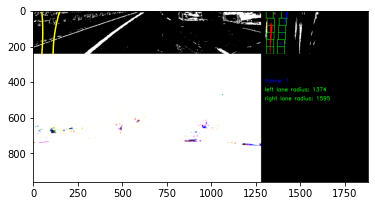

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


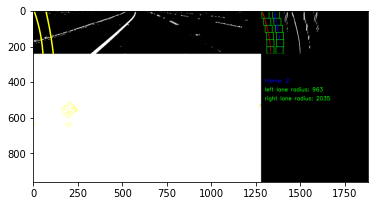

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


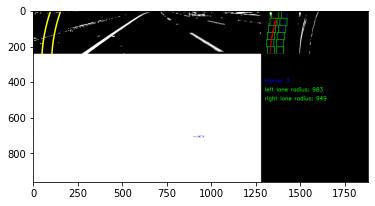

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


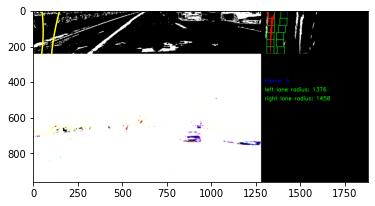

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


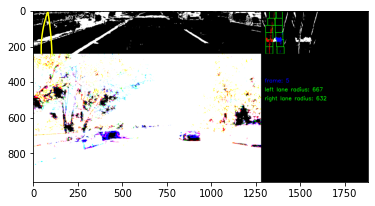

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


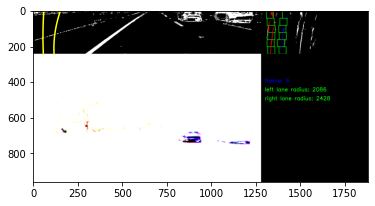

In [1187]:
os.listdir("test_images/")

for image in range(len(os.listdir("test_images/"))):
    img_dir="test_images/"+os.listdir("test_images")[image]
    image = mpimg.imread(img_dir)    
    img_output = pipeline_img(image)

    plt.imshow(img_output)
    plt.pause(0.2) 

In [1188]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
Wall time: 18min 22s


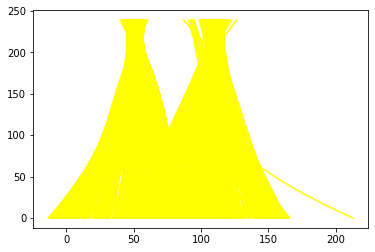

In [1190]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(35,41)
clip1 = VideoFileClip("test_videos/project_video.mp4")
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,3)

white_clip = clip1.fl_image(pipeline_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)